# Import packages

In [36]:
import pywikibot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
random.seed(16021997)
from tqdm import tqdm
import concurrent.futures
from itertools import combinations
from datetime import datetime
import copy

import requests
import bs4

# Scrape table with list of Wikipedias by number of articles

In [2]:
res = requests.get("https://meta.wikimedia.org/wiki/List_of_Wikipedias")
soup = bs4.BeautifulSoup(res.text, 'html.parser')

In [3]:
table = soup.find('table', class_='wikitable')
header_row = table.find('tr')
headers = [header.text.strip() for header in header_row.find_all('th')]
data_wikis = []

In [4]:
for row in table.find_all('tr'):
    columns = row.find_all('td')
    if columns:
        column_data = [column.text.strip() for column in columns]
        data_wikis.append(column_data)

In [5]:
df_wikis = pd.DataFrame(data_wikis, columns=headers)
df_wikis.drop('№',axis=1,inplace=True)
for col in ['Articles','All pages','Edits','Admins','Users','Active users','Files','Depth']:
    df_wikis[col] = df_wikis[col].str.replace(',', '')
    df_wikis[col] = df_wikis[col].astype(int)

In [6]:
df_wikis = df_wikis[(df_wikis.Wiki != 'ceb') & (df_wikis.Wiki != 'sv') & (df_wikis.Wiki != 'war')].reset_index(drop=True) # Dropping Cebuano, Swedish, and Waray

In [7]:
nr_articles_by_wiki = dict(zip(df_wikis.head(20).Wiki,df_wikis.head(20).Articles))

In [8]:
wiki_language_mapping = dict(zip(df_wikis.head(20).Wiki,df_wikis.head(20).Language))

In [9]:
df_wikis.head(20)

,Language,Language (local),Wiki,Articles,All pages,Edits,Admins,Users,Active users,Files,Depth
0,English,English,en,6675317,58435617,1157445856,898,45764509,116318,905296,1190
1,German,Deutsch,de,2812632,7760507,233438533,180,4176895,17079,127887,93
2,French,français,fr,2531935,12615322,205048124,152,4689268,17348,71265,257
3,Dutch,Nederlands,nl,2125576,4542726,64422579,34,1283874,3847,20,18
4,Russian,русский,ru,1924627,7723814,131007962,72,3409953,10292,244093,153
5,Spanish,español,es,1873518,7937431,151658008,59,6884172,15470,0,200
6,Italian,italiano,it,1816256,7747775,133869089,120,2397935,7953,130504,184
7,Egyptian Arabic,مصرى,arz,1618032,2075500,8162082,7,213544,213,1483,0
8,Polish,polski,pl,1572137,3623571,70531884,99,1245357,4307,260,33
9,Japanese,日本語,ja,1378401,4057870,95586022,41,2086222,14284,4514,89


# Extract language connections from a sample of pages

Each Wiki will be sampled in proportion to its # of articles.

In [10]:
rescaling_factor = 0.003 # We'll sample only this proportion of pages from each wiki

In [11]:
#nr_articles_by_wiki = {'it':100000}

In [12]:
def process_article(site, article):
    page = pywikibot.Page(site, article.title())
    langlinks = [langlink.site.lang for langlink in page.langlinks() if langlink.site.lang in nr_articles_by_wiki.keys()]
    try:
        page_id = page.data_item()
    except:
        page_id = datetime.now().strftime("%H:%M:%S.%f")
    return page_id, langlinks + [site.code], len(page.text)

In [13]:
# Slow code version
'''dict_data = {}
for wiki_version, nr_articles in tqdm(nr_articles_by_wiki.items(), desc='Outer loop'):
    site = pywikibot.Site(wiki_version, "wikipedia")
    sampled_articles = list(site.randompages(total=max(int(nr_articles * rescaling_factor), 1), namespaces=[0])) # We want to select at least one article per Wiki

    for article in tqdm(sampled_articles, desc='Inner loop'):
        page = pywikibot.Page(site, article.title())
        langlinks = [langlink.site.lang for langlink in page.langlinks()]
        dict_data[page.data_item()] = langlinks + [wiki_version]'''

'dict_data = {}\nfor wiki_version, nr_articles in tqdm(nr_articles_by_wiki.items(), desc=\'Outer loop\'):\n    site = pywikibot.Site(wiki_version, "wikipedia")\n    sampled_articles = list(site.randompages(total=max(int(nr_articles * rescaling_factor), 1), namespaces=[0])) # We want to select at least one article per Wiki\n\n    for article in tqdm(sampled_articles, desc=\'Inner loop\'):\n        page = pywikibot.Page(site, article.title())\n        langlinks = [langlink.site.lang for langlink in page.langlinks()]\n        dict_data[page.data_item()] = langlinks + [wiki_version]'

In [14]:
# Fast code version
dict_data = {}

with concurrent.futures.ThreadPoolExecutor() as executor:
    for wiki_version, nr_articles in tqdm(nr_articles_by_wiki.items(), desc='Outer loop'):
        site = pywikibot.Site(wiki_version, "wikipedia")
        sampled_articles = list(site.randompages(total=max(int(nr_articles * rescaling_factor), 1), namespaces=[0])) # We want to select at least one article per Wiki

        future_to_article = {executor.submit(process_article, site, article): article for article in sampled_articles}

        for future in tqdm(concurrent.futures.as_completed(future_to_article), desc='Inner loop', total=len(future_to_article)):
            article = future_to_article[future]
            result = future.result()
            dict_data[result[0]] = [result[1], result[2]]

Inner loop:   0%|                            | 22/20025 [00:03<29:28, 11.31it/s]WARNING: /Users/federico.bindi/anaconda3/envs/baseplus/lib/python3.10/site-packages/pywikibot/page/_links.py:612: UserWarning: Site wikipedia:no instantiated using different code "nb"
  link._site = pywikibot.Site(lang, source.family.name)


Inner loop:   0%|                            | 56/20025 [00:06<25:22, 13.12it/s]WARNING: /Users/federico.bindi/anaconda3/envs/baseplus/lib/python3.10/site-packages/pywikibot/page/_links.py:612: UserWarning: Site wikipedia:be-tarask instantiated using different code "be-x-old"
  link._site = pywikibot.Site(lang, source.family.name)


Inner loop:   1%|▎                          | 265/20025 [00:19<23:42, 13.89it/s]


Inner loop:   3%|▊                          | 605/20025 [00:39<18:13, 17.75it/s]


Inner loop:   5%|█▎                         | 935/20025 [00:59<26:13, 12.13it/s]


Inner loop:   6%|█▋                        | 1275/20025 [01:19<18:13, 17.15it/s]


Inner loop:   8%|██                        | 1605/20025 [01:39<21:55, 14.00it/s]


Inner loop:  10%|██▍                       | 1924/20025 [01:57<16:56, 17.80it/s]


Inner loop:  11%|██▉                       | 2243/20025 [02:16<16:38, 17.81it/s]


Inner loop:  13%|███▎                      | 2550/20025 [02:34<15:25, 18.89it/s]


Inner loop:  14%|███▋                      | 2851/20025 [02:52<13:13, 21.63it/s]


Inner loop:  16%|████                      | 3167/20025 [03:11<18:42, 15.02it/s]


Inner loop:  17%|████▌                     | 3494/20025 [03:31<22:30, 12.24it/s]


Inner loop:  19%|████▉                     | 3806/20025 [03:49<16:49, 16.06it/s]


Inner loop:  21%|█████▎                    | 4121/20025 [04:08<15:14, 17.39it/s]


Inner loop:  22%|█████▊                    | 4452/20025 [04:28<15:35, 16.65it/s]


Inner loop:  24%|██████▏                   | 4773/20025 [04:48<14:27, 17.59it/s]


Inner loop:  25%|██████▌                   | 5090/20025 [05:07<13:34, 18.35it/s]


Inner loop:  27%|███████                   | 5400/20025 [05:26<13:18, 18.31it/s]


Inner loop:  29%|███████▍                  | 5710/20025 [05:45<17:09, 13.90it/s]


Inner loop:  30%|███████▊                  | 6028/20025 [06:04<23:35,  9.89it/s]


Inner loop:  32%|████████▏                 | 6350/20025 [06:23<11:23, 20.00it/s]


Inner loop:  33%|████████▋                 | 6678/20025 [06:44<11:22, 19.55it/s]


Inner loop:  35%|█████████                 | 6987/20025 [07:02<12:04, 17.99it/s]


Inner loop:  37%|█████████▌                | 7317/20025 [07:22<11:23, 18.60it/s]


Inner loop:  38%|█████████▉                | 7646/20025 [07:42<10:36, 19.44it/s]


Inner loop:  40%|██████████▎               | 7976/20025 [08:02<10:10, 19.74it/s]


Inner loop:  41%|██████████▊               | 8299/20025 [08:22<12:11, 16.03it/s]


Inner loop:  43%|███████████▏              | 8617/20025 [08:42<10:51, 17.52it/s]


Inner loop:  45%|███████████▌              | 8936/20025 [09:02<13:33, 13.64it/s]


Inner loop:  46%|███████████▉              | 9236/20025 [09:21<11:41, 15.38it/s]


Inner loop:  48%|████████████▍             | 9549/20025 [09:40<12:08, 14.38it/s]


Inner loop:  49%|████████████▊             | 9845/20025 [09:59<15:18, 11.08it/s]


Inner loop:  51%|████████████▋            | 10142/20025 [10:17<09:40, 17.02it/s]


Inner loop:  52%|█████████████            | 10413/20025 [10:37<09:55, 16.14it/s]


Inner loop:  54%|█████████████▍           | 10718/20025 [10:57<09:50, 15.76it/s]


Inner loop:  55%|█████████████▋           | 11009/20025 [11:19<30:32,  4.92it/s]


Inner loop:  56%|██████████████           | 11290/20025 [11:37<09:39, 15.06it/s]


Inner loop:  58%|██████████████▍          | 11597/20025 [11:57<08:24, 16.70it/s]


Inner loop:  59%|██████████████▊          | 11902/20025 [12:15<08:05, 16.74it/s]


Inner loop:  61%|███████████████▏         | 12213/20025 [12:34<07:00, 18.60it/s]


Inner loop:  63%|███████████████▋         | 12529/20025 [12:53<06:25, 19.45it/s]


Inner loop:  64%|████████████████         | 12859/20025 [13:14<17:10,  6.95it/s]


Inner loop:  66%|████████████████▍        | 13178/20025 [13:34<08:12, 13.90it/s]


Inner loop:  67%|████████████████▊        | 13470/20025 [13:54<08:19, 13.12it/s]


Inner loop:  69%|█████████████████▏       | 13786/20025 [14:12<05:54, 17.61it/s]


Inner loop:  70%|█████████████████▌       | 14096/20025 [14:31<08:41, 11.38it/s]


Inner loop:  72%|█████████████████▉       | 14415/20025 [14:49<05:47, 16.16it/s]


Inner loop:  73%|██████████████████▎      | 14709/20025 [15:06<04:32, 19.54it/s]


Inner loop:  75%|██████████████████▋      | 15006/20025 [15:25<05:00, 16.69it/s]


Inner loop:  77%|███████████████████▏     | 15323/20025 [15:43<04:50, 16.21it/s]


Inner loop:  78%|███████████████████▌     | 15635/20025 [16:03<05:44, 12.75it/s]


Inner loop:  80%|███████████████████▉     | 15941/20025 [16:21<04:34, 14.87it/s]


Inner loop:  81%|████████████████████▎    | 16259/20025 [16:39<03:21, 18.69it/s]


Inner loop:  83%|████████████████████▋    | 16589/20025 [17:00<03:32, 16.17it/s]


Inner loop:  85%|█████████████████████▏   | 16922/20025 [17:21<02:38, 19.57it/s]


Inner loop:  86%|█████████████████████▌   | 17247/20025 [17:40<02:45, 16.78it/s]


Inner loop:  88%|█████████████████████▉   | 17564/20025 [18:01<02:29, 16.48it/s]


Inner loop:  89%|██████████████████████▎  | 17903/20025 [18:20<01:45, 20.10it/s]


Inner loop:  91%|██████████████████████▋  | 18212/20025 [18:39<01:41, 17.94it/s]


Inner loop:  92%|███████████████████████  | 18511/20025 [18:57<01:36, 15.69it/s]


Inner loop:  94%|███████████████████████▌ | 18831/20025 [19:16<01:03, 18.69it/s]


Inner loop:  96%|███████████████████████▉ | 19135/20025 [19:36<01:35,  9.36it/s]


Inner loop:  97%|████████████████████████▎| 19448/20025 [19:55<00:30, 18.78it/s]


Inner loop:  99%|████████████████████████▋| 19754/20025 [20:13<00:15, 17.67it/s]


Inner loop:   1%|▎                            | 80/8437 [00:05<08:07, 17.16it/s]


Inner loop:   5%|█▎                          | 386/8437 [00:23<07:15, 18.47it/s]


Inner loop:   8%|██▎                         | 690/8437 [00:42<08:13, 15.70it/s]


Inner loop:  12%|███▏                       | 1004/8437 [01:01<05:53, 21.02it/s]


Inner loop:  16%|████▏                      | 1325/8437 [01:20<06:40, 17.74it/s]


Inner loop:  19%|█████▏                     | 1638/8437 [01:41<13:45,  8.24it/s]


Inner loop:  23%|██████▎                    | 1957/8437 [02:01<06:54, 15.65it/s]


Inner loop:  27%|███████▏                   | 2259/8437 [02:20<05:54, 17.44it/s]


Inner loop:  31%|████████▏                  | 2577/8437 [02:39<05:33, 17.58it/s]


Inner loop:  34%|█████████▏                 | 2883/8437 [02:58<05:56, 15.60it/s]


Inner loop:  38%|██████████▏                | 3196/8437 [03:18<05:02, 17.34it/s]


Inner loop:  42%|███████████▏               | 3508/8437 [03:37<07:32, 10.89it/s]


Inner loop:  45%|████████████▎              | 3834/8437 [03:57<08:58,  8.55it/s]


Inner loop:  49%|█████████████▎             | 4175/8437 [04:18<05:40, 12.50it/s]


Inner loop:  53%|██████████████▎            | 4487/8437 [04:35<03:45, 17.49it/s]


Inner loop:  57%|███████████████▍           | 4809/8437 [04:55<03:58, 15.24it/s]


Inner loop:  61%|████████████████▍          | 5145/8437 [05:15<02:29, 21.96it/s]


Inner loop:  65%|█████████████████▍         | 5464/8437 [05:35<02:49, 17.53it/s]


Inner loop:  69%|██████████████████▌        | 5789/8437 [05:55<02:19, 18.97it/s]


Inner loop:  72%|███████████████████▌       | 6108/8437 [06:15<02:09, 18.02it/s]


Inner loop:  76%|████████████████████▌      | 6422/8437 [06:34<01:42, 19.59it/s]


Inner loop:  80%|█████████████████████▋     | 6774/8437 [06:56<01:32, 18.01it/s]


Inner loop:  84%|██████████████████████▋    | 7106/8437 [07:16<01:07, 19.77it/s]


Inner loop:  88%|███████████████████████▊   | 7439/8437 [07:37<04:11,  3.97it/s]


Inner loop:  92%|████████████████████████▊  | 7756/8437 [07:54<00:38, 17.65it/s]


Inner loop:  96%|█████████████████████████▊ | 8070/8437 [08:13<00:19, 18.99it/s]


Inner loop:  99%|██████████████████████████▊| 8385/8437 [08:33<00:03, 14.32it/s]


Inner loop:   4%|█                           | 277/7595 [00:18<06:43, 18.13it/s]


Inner loop:   8%|██▏                         | 582/7595 [00:38<21:43,  5.38it/s]


Inner loop:  12%|███▎                        | 908/7595 [00:55<05:19, 20.93it/s]


Inner loop:  16%|████▎                      | 1225/7595 [01:15<06:43, 15.78it/s]


Inner loop:  20%|█████▌                     | 1550/7595 [01:35<06:04, 16.58it/s]


Inner loop:  25%|██████▋                    | 1876/7595 [01:56<08:05, 11.78it/s]


Inner loop:  29%|███████▊                   | 2201/7595 [02:14<05:11, 17.29it/s]


Inner loop:  33%|████████▉                  | 2509/7595 [02:34<04:32, 18.66it/s]


Inner loop:  37%|██████████                 | 2828/7595 [02:54<04:04, 19.50it/s]


Inner loop:  42%|███████████▎               | 3166/7595 [03:13<03:36, 20.49it/s]


Inner loop:  46%|████████████▎              | 3479/7595 [03:33<04:08, 16.59it/s]


Inner loop:  50%|█████████████▍             | 3789/7595 [03:53<03:33, 17.85it/s]


Inner loop:  54%|██████████████▌            | 4112/7595 [04:14<17:25,  3.33it/s]


Inner loop:  58%|███████████████▋           | 4428/7595 [04:31<02:26, 21.63it/s]


Inner loop:  63%|████████████████▉          | 4752/7595 [04:52<02:44, 17.27it/s]


Inner loop:  67%|██████████████████         | 5085/7595 [05:14<04:20,  9.64it/s]


Inner loop:  71%|███████████████████▏       | 5382/7595 [05:31<02:18, 15.99it/s]


Inner loop:  75%|████████████████████▎      | 5706/7595 [05:53<01:46, 17.82it/s]


Inner loop:  79%|█████████████████████▍     | 6022/7595 [06:10<01:15, 20.75it/s]


Inner loop:  83%|██████████████████████▌    | 6341/7595 [06:31<01:25, 14.75it/s]


Inner loop:  88%|███████████████████████▋   | 6656/7595 [06:52<00:49, 18.98it/s]


Inner loop:  92%|████████████████████████▊  | 6982/7595 [07:10<00:36, 16.72it/s]


Inner loop:  96%|█████████████████████████▉ | 7301/7595 [07:31<00:15, 18.95it/s]


Inner loop:   0%|                                      | 0/6376 [00:00<?, ?it/s]Could not load cache: EOFError('Ran out of input')

Inner loop:   0%|                             | 11/6376 [00:01<09:25, 11.26it/s]


Inner loop:   5%|█▌                          | 347/6376 [00:19<06:42, 15.00it/s]


Inner loop:  11%|██▉                         | 681/6376 [00:41<04:39, 20.36it/s]


Inner loop:  16%|████▎                      | 1012/6376 [00:59<04:48, 18.59it/s]


Inner loop:  21%|█████▋                     | 1336/6376 [01:20<04:44, 17.73it/s]


Inner loop:  26%|███████                    | 1667/6376 [01:42<04:41, 16.74it/s]


Inner loop:  31%|████████▍                  | 1988/6376 [02:00<04:29, 16.31it/s]


Inner loop:  36%|█████████▋                 | 2293/6376 [02:20<03:16, 20.82it/s]


Inner loop:  41%|███████████                | 2611/6376 [02:37<03:27, 18.18it/s]


Inner loop:  46%|████████████▎              | 2910/6376 [02:57<03:02, 19.04it/s]


Inner loop:  50%|█████████████▌             | 3211/6376 [03:14<02:55, 18.07it/s]


Inner loop:  55%|██████████████▉            | 3522/6376 [03:35<02:37, 18.11it/s]


Inner loop:  60%|████████████████▎          | 3842/6376 [03:52<02:04, 20.40it/s]


Inner loop:  65%|█████████████████▌         | 4162/6376 [04:13<01:47, 20.55it/s]


Inner loop:  70%|██████████████████▉        | 4483/6376 [04:31<01:50, 17.09it/s]


Inner loop:  75%|████████████████████▎      | 4793/6376 [04:52<01:19, 19.86it/s]


Inner loop:  80%|█████████████████████▋     | 5129/6376 [05:10<01:01, 20.34it/s]


Inner loop:  86%|███████████████████████▏   | 5464/6376 [05:32<00:44, 20.60it/s]


Inner loop:  91%|████████████████████████▌  | 5787/6376 [05:50<00:30, 19.14it/s]


Inner loop:  96%|█████████████████████████▉ | 6124/6376 [06:13<00:12, 19.74it/s]


Inner loop:   0%|                                      | 0/5773 [00:00<?, ?it/s]Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')

Inner loop:   1%|▏                            | 31/5773 [00:02<05:39, 16.93it/s]


Inner loop:   5%|█▌                          | 312/5773 [00:23<05:56, 15.31it/s]


Inner loop:  10%|██▉                         | 602/5773 [00:39<04:15, 20.27it/s]


Inner loop:  16%|████▌                       | 940/5773 [01:03<04:19, 18.63it/s]


Inner loop:  21%|█████▊                     | 1239/5773 [01:20<03:35, 21.00it/s]


Inner loop:  27%|███████▏                   | 1536/5773 [01:42<04:39, 15.14it/s]


Inner loop:  32%|████████▋                  | 1858/5773 [02:00<03:53, 16.75it/s]


Inner loop:  37%|██████████                 | 2155/5773 [02:22<03:06, 19.40it/s]


Inner loop:  43%|███████████▌               | 2460/5773 [02:39<03:02, 18.14it/s]


Inner loop:  48%|████████████▉              | 2763/5773 [03:01<03:07, 16.02it/s]


Inner loop:  53%|██████████████▍            | 3079/5773 [03:19<03:02, 14.76it/s]


Inner loop:  59%|███████████████▊           | 3378/5773 [03:41<08:44,  4.57it/s]


Inner loop:  64%|█████████████████▎         | 3698/5773 [04:00<01:58, 17.53it/s]


Inner loop:  69%|██████████████████▋        | 3996/5773 [04:16<01:44, 17.06it/s]


Inner loop:  74%|████████████████████       | 4291/5773 [04:38<01:27, 16.90it/s]


Inner loop:  79%|█████████████████████▍     | 4578/5773 [04:55<01:11, 16.76it/s]


Inner loop:  85%|██████████████████████▉    | 4892/5773 [05:18<00:55, 15.82it/s]


Inner loop:  90%|████████████████████████▎  | 5197/5773 [05:35<00:25, 22.55it/s]


Inner loop:  95%|█████████████████████████▊ | 5513/5773 [05:58<00:41,  6.19it/s]


Inner loop:   0%|                                      | 0/5620 [00:00<?, ?it/s]Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')

Inner loop:   1%|▎                            | 59/5620 [00:04<04:30, 20.57it/s]


Inner loop:   7%|█▉                          | 393/5620 [00:22<04:27, 19.56it/s]


Inner loop:  12%|███▍                        | 694/5620 [00:43<04:36, 17.81it/s]


Inner loop:  18%|████▊                      | 1001/5620 [01:00<04:30, 17.10it/s]


Inner loop:  23%|██████▎                    | 1318/5620 [01:22<03:27, 20.76it/s]


Inner loop:  29%|███████▉                   | 1642/5620 [01:40<03:04, 21.60it/s]


Inner loop:  35%|█████████▎                 | 1941/5620 [02:01<35:41,  1.72it/s]ERROR: Traceback (most recent call last):
  File "/Users/federico.bindi/anaconda3/envs/baseplus/lib/python3.10/site-packages/pywikibot/data/api/_requests.py", line 681, in _http_request
    response = http.request(self.site, uri=uri,
  File "/Users/federico.bindi/anaconda3/envs/baseplus/lib/python3.10/site-packages/pywikibot/comms/http.py", line 282, in request
    r = fetch(baseuri, headers=headers, **kwargs)
  File "/Users/federico.bindi/anaconda3/envs/baseplus/lib/python3.10/site-packages/pywikibot/comms/http.py", line 448, in fetch
    callback(response)
  File "/Users/federico.bindi/anaconda3/envs/baseplus/lib/python3.10/site-packages/pywikibot/comms/http.py", line 344, in error_handling_callback
    raise ServerError(
pywikibot.exceptions.ServerError: 503 Server Error: Backend fetch failed




Inner loop:  40%|██████████▉                | 2267/5620 [02:19<03:06, 18.01it/s]


Inner loop:  46%|████████████▍              | 2579/5620 [02:36<02:18, 21.99it/s]


Inner loop:  52%|█████████████▉             | 2896/5620 [02:59<02:40, 16.94it/s]


Inner loop:  57%|███████████████▍           | 3210/5620 [03:15<02:19, 17.28it/s]


Inner loop:  63%|████████████████▉          | 3523/5620 [03:38<05:43,  6.10it/s]


Inner loop:  69%|██████████████████▌        | 3861/5620 [03:56<01:38, 17.91it/s]


Inner loop:  75%|████████████████████▏      | 4193/5620 [04:14<01:25, 16.75it/s]


Inner loop:  80%|█████████████████████▋     | 4509/5620 [04:37<01:07, 16.37it/s]


Inner loop:  86%|███████████████████████▏   | 4828/5620 [04:54<00:39, 19.89it/s]


Inner loop:  91%|████████████████████████▋  | 5136/5620 [05:10<00:24, 19.88it/s]


Inner loop:  97%|██████████████████████████▎| 5475/5620 [05:34<00:06, 22.17it/s]


Inner loop:   3%|▉                           | 186/5448 [00:11<04:23, 19.99it/s]


Inner loop:  10%|██▋                         | 522/5448 [00:35<04:57, 16.57it/s]


Inner loop:  15%|████▎                       | 830/5448 [00:52<04:20, 17.72it/s]


Inner loop:  21%|█████▌                     | 1127/5448 [01:09<03:58, 18.11it/s]


Inner loop:  27%|███████▏                   | 1446/5448 [01:33<03:44, 17.84it/s]


Inner loop:  32%|████████▋                  | 1760/5448 [01:49<02:45, 22.29it/s]


Inner loop:  38%|██████████▎                | 2082/5448 [02:14<05:09, 10.89it/s]


Inner loop:  44%|███████████▊               | 2387/5448 [02:31<03:06, 16.43it/s]


Inner loop:  50%|█████████████▍             | 2701/5448 [02:48<02:47, 16.38it/s]


Inner loop:  56%|███████████████            | 3034/5448 [03:12<01:49, 21.96it/s]


Inner loop:  62%|████████████████▋          | 3360/5448 [03:32<02:43, 12.76it/s]


Inner loop:  67%|██████████████████         | 3655/5448 [03:51<01:41, 17.63it/s]


Inner loop:  73%|███████████████████▋       | 3971/5448 [04:16<01:20, 18.31it/s]


Inner loop:  78%|█████████████████████▏     | 4272/5448 [04:33<00:55, 21.03it/s]


Inner loop:  84%|██████████████████████▋    | 4575/5448 [04:50<00:43, 19.90it/s]


Inner loop:  90%|████████████████████████▎  | 4903/5448 [05:14<04:07,  2.20it/s]


Inner loop:  96%|█████████████████████████▊ | 5207/5448 [05:31<00:13, 18.02it/s]


Inner loop:   2%|▌                            | 91/4854 [00:05<04:42, 16.86it/s]


Inner loop:   8%|██▎                         | 403/4854 [00:23<04:21, 17.04it/s]


Inner loop:  15%|████                        | 715/4854 [00:46<03:55, 17.57it/s]


Inner loop:  21%|█████▊                     | 1035/4854 [01:04<03:05, 20.64it/s]


Inner loop:  28%|███████▌                   | 1361/4854 [01:21<02:53, 20.09it/s]


Inner loop:  35%|█████████▍                 | 1689/4854 [01:46<14:03,  3.75it/s]


Inner loop:  41%|███████████                | 1995/4854 [02:02<02:36, 18.26it/s]


Inner loop:  48%|████████████▉              | 2320/4854 [02:20<02:09, 19.62it/s]


Inner loop:  55%|██████████████▋            | 2646/4854 [02:38<02:11, 16.80it/s]


Inner loop:  61%|████████████████▍          | 2962/4854 [03:02<01:43, 18.26it/s]


Inner loop:  67%|██████████████████▏        | 3265/4854 [03:18<01:30, 17.61it/s]


Inner loop:  74%|███████████████████▉       | 3592/4854 [03:36<01:03, 19.73it/s]


Inner loop:  80%|█████████████████████▍     | 3864/4854 [03:58<01:46,  9.32it/s]


Inner loop:  84%|██████████████████████▊    | 4100/4854 [04:20<01:26,  8.74it/s]


Inner loop:  91%|████████████████████████▍  | 4399/4854 [04:47<00:20, 22.06it/s]


Inner loop:  97%|██████████████████████████▏| 4716/4854 [05:05<00:07, 18.54it/s]


Inner loop:   0%|                                      | 0/4716 [00:00<?, ?it/s]Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')

Inner loop:   3%|▉                           | 162/4716 [00:09<03:38, 20.80it/s]


Inner loop:  10%|██▉                         | 485/4716 [00:27<04:09, 16.96it/s]


Inner loop:  17%|████▋                       | 799/4716 [00:52<04:03, 16.08it/s]


Inner loop:  23%|██████▎                    | 1103/4716 [01:09<03:16, 18.42it/s]


Inner loop:  30%|████████                   | 1418/4716 [01:26<03:20, 16.48it/s]


Inner loop:  37%|██████████                 | 1766/4716 [01:45<02:48, 17.52it/s]


Inner loop:  44%|████████████               | 2096/4716 [02:12<02:56, 14.81it/s]


Inner loop:  51%|█████████████▊             | 2410/4716 [02:29<01:52, 20.48it/s]


Inner loop:  58%|███████████████▌           | 2720/4716 [02:46<01:55, 17.30it/s]


Inner loop:  64%|█████████████████▍         | 3038/4716 [03:03<01:28, 18.92it/s]


Inner loop:  72%|███████████████████▎       | 3377/4716 [03:30<01:35, 14.02it/s]


Inner loop:  78%|█████████████████████      | 3684/4716 [03:47<00:45, 22.93it/s]


Inner loop:  85%|██████████████████████▉    | 4001/4716 [04:05<00:44, 16.23it/s]


Inner loop:  91%|████████████████████████▋  | 4312/4716 [04:22<00:21, 18.90it/s]


Inner loop:  98%|██████████████████████████▌| 4634/4716 [04:40<00:04, 19.53it/s]


Inner loop:   0%|                                      | 0/4135 [00:00<?, ?it/s]Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')

Inner loop:   6%|█▋                          | 249/4135 [00:23<03:31, 18.37it/s]


Inner loop:  14%|███▊                        | 559/4135 [00:41<03:06, 19.17it/s]


Inner loop:  21%|█████▉                      | 874/4135 [00:59<03:10, 17.11it/s]


Inner loop:  30%|███████▉                   | 1224/4135 [01:18<03:07, 15.53it/s]


Inner loop:  37%|██████████                 | 1544/4135 [01:36<02:23, 18.00it/s]


Inner loop:  45%|████████████▏              | 1863/4135 [02:02<02:24, 15.73it/s]


Inner loop:  53%|██████████████▏            | 2175/4135 [02:19<01:32, 21.17it/s]


Inner loop:  60%|████████████████▎          | 2489/4135 [02:37<01:48, 15.18it/s]


Inner loop:  68%|██████████████████▍        | 2816/4135 [02:55<01:21, 16.27it/s]


Inner loop:  75%|████████████████████▎      | 3115/4135 [03:21<01:21, 12.49it/s]


Inner loop:  83%|██████████████████████▍    | 3430/4135 [03:38<00:29, 23.96it/s]


Inner loop:  90%|████████████████████████▍  | 3741/4135 [03:56<00:20, 19.24it/s]


Inner loop:  98%|██████████████████████████▍| 4050/4135 [04:13<00:04, 17.13it/s]


Inner loop:   0%|                                      | 0/4091 [00:00<?, ?it/s]Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')

Inner loop:   6%|█▌                          | 229/4091 [00:13<03:55, 16.41it/s]


Inner loop:  14%|███▊                        | 566/4091 [00:41<03:26, 17.09it/s]


Inner loop:  21%|█████▉                      | 867/4091 [00:58<03:07, 17.24it/s]


Inner loop:  29%|███████▊                   | 1178/4091 [01:15<03:06, 15.66it/s]


Inner loop:  36%|█████████▊                 | 1482/4091 [01:32<02:03, 21.20it/s]


Inner loop:  44%|███████████▉               | 1804/4091 [01:50<01:27, 26.14it/s]


Inner loop:  52%|██████████████             | 2124/4091 [02:16<01:49, 18.02it/s]


Inner loop:  60%|████████████████           | 2443/4091 [02:34<01:35, 17.27it/s]


Inner loop:  67%|██████████████████▏        | 2756/4091 [02:52<01:19, 16.85it/s]


Inner loop:  74%|████████████████████       | 3032/4091 [03:10<00:58, 18.20it/s]


Inner loop:  82%|██████████████████████     | 3352/4091 [03:28<00:48, 15.22it/s]


Inner loop:  90%|████████████████████████▏  | 3667/4091 [03:45<00:19, 21.39it/s]


Inner loop:  97%|██████████████████████████▎| 3984/4091 [04:13<00:06, 16.86it/s]


Inner loop:   6%|█▋                          | 233/3854 [00:13<03:12, 18.76it/s]


Inner loop:  14%|███▉                        | 538/3854 [00:30<03:20, 16.56it/s]


Inner loop:  22%|██████                      | 836/3854 [00:46<02:47, 18.01it/s]


Inner loop:  29%|███████▊                   | 1120/3854 [01:05<03:55, 11.59it/s]


Inner loop:  36%|█████████▋                 | 1381/3854 [01:34<02:15, 18.29it/s]


Inner loop:  44%|███████████▊               | 1685/3854 [01:51<02:09, 16.81it/s]


Inner loop:  51%|█████████████▉             | 1984/3854 [02:08<01:46, 17.54it/s]


Inner loop:  59%|████████████████           | 2286/3854 [02:28<01:48, 14.49it/s]


Inner loop:  66%|█████████████████▊         | 2551/3854 [02:47<01:46, 12.22it/s]


Inner loop:  74%|███████████████████▉       | 2846/3854 [03:05<01:12, 13.81it/s]


Inner loop:  81%|█████████████████████▉     | 3139/3854 [03:32<00:39, 18.17it/s]


Inner loop:  90%|████████████████████████▏  | 3457/3854 [03:49<00:25, 15.75it/s]


Inner loop:  98%|██████████████████████████▍| 3768/3854 [04:06<00:04, 18.25it/s]


Inner loop:   6%|█▊                          | 243/3810 [00:14<03:11, 18.61it/s]


Inner loop:  14%|███▉                        | 544/3810 [00:31<02:42, 20.07it/s]


Inner loop:  22%|██████▏                     | 840/3810 [00:59<02:38, 18.69it/s]


Inner loop:  30%|████████▏                  | 1156/3810 [01:16<02:40, 16.50it/s]


Inner loop:  38%|██████████▍                | 1466/3810 [01:34<02:17, 17.04it/s]


Inner loop:  47%|████████████▌              | 1775/3810 [01:51<01:53, 17.97it/s]


Inner loop:  54%|██████████████▋            | 2066/3810 [02:07<01:40, 17.36it/s]


Inner loop:  62%|████████████████▊          | 2379/3810 [02:25<01:25, 16.73it/s]


Inner loop:  70%|██████████████████▉        | 2675/3810 [02:53<00:57, 19.68it/s]


Inner loop:  78%|█████████████████████▏     | 2986/3810 [03:10<00:54, 15.04it/s]


Inner loop:  87%|███████████████████████▍   | 3304/3810 [03:29<00:32, 15.41it/s]


Inner loop:  95%|█████████████████████████▋ | 3619/3810 [03:47<00:11, 16.52it/s]


Inner loop:   3%|▉                           | 124/3628 [00:08<03:23, 17.22it/s]


Inner loop:  13%|███▌                        | 460/3628 [00:26<03:08, 16.81it/s]


Inner loop:  21%|█████▉                      | 771/3628 [00:55<02:31, 18.91it/s]


Inner loop:  30%|████████                   | 1081/3628 [01:12<02:18, 18.42it/s]


Inner loop:  38%|██████████▎                | 1391/3628 [01:28<02:05, 17.83it/s]


Inner loop:  47%|████████████▋              | 1697/3628 [01:45<01:52, 17.14it/s]


Inner loop:  56%|███████████████▏           | 2035/3628 [02:03<01:11, 22.18it/s]


Inner loop:  65%|█████████████████▌         | 2358/3628 [02:33<04:18,  4.92it/s]


Inner loop:  73%|███████████████████▊       | 2657/3628 [02:51<01:04, 15.13it/s]


Inner loop:  80%|█████████████████████▋     | 2917/3628 [03:09<01:14,  9.56it/s]


Inner loop:  88%|███████████████████████▋   | 3190/3628 [03:29<00:25, 17.29it/s]


Inner loop:  97%|██████████████████████████ | 3502/3628 [03:47<00:07, 17.66it/s]


Inner loop:   0%|                                      | 0/3311 [00:00<?, ?it/s]Could not load cache: EOFError('Ran out of input')

Inner loop:   5%|█▍                          | 173/3311 [00:11<02:59, 17.52it/s]


Inner loop:  15%|████                        | 482/3311 [00:28<02:17, 20.64it/s]


Inner loop:  23%|██████▍                     | 767/3311 [00:57<02:05, 20.29it/s]


Inner loop:  32%|████████▌                  | 1053/3311 [01:13<02:27, 15.27it/s]


Inner loop:  41%|███████████▏               | 1367/3311 [01:30<01:39, 19.56it/s]


Inner loop:  51%|█████████████▋             | 1678/3311 [01:48<01:32, 17.59it/s]


Inner loop:  60%|████████████████▎          | 1993/3311 [02:05<01:10, 18.73it/s]


Inner loop:  70%|██████████████████▊        | 2302/3311 [02:22<00:47, 21.38it/s]


Inner loop:  80%|█████████████████████▌     | 2637/3311 [02:53<00:40, 16.82it/s]


Inner loop:  89%|████████████████████████   | 2957/3311 [03:11<00:19, 18.24it/s]


Inner loop:  98%|██████████████████████████▌| 3258/3311 [03:27<00:02, 17.91it/s]


Inner loop:   0%|                                      | 0/2899 [00:00<?, ?it/s]Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')

Inner loop:   8%|██▎                         | 241/2899 [00:14<02:21, 18.85it/s]


Inner loop:  19%|█████▎                      | 548/2899 [00:31<02:02, 19.16it/s]


Inner loop:  29%|████████▏                   | 851/2899 [00:48<01:33, 21.93it/s]


Inner loop:  40%|██████████▋                | 1153/2899 [01:17<09:38,  3.02it/s]


Inner loop:  50%|█████████████▌             | 1459/2899 [01:34<01:32, 15.65it/s]


Inner loop:  61%|████████████████▌          | 1781/2899 [01:52<00:57, 19.32it/s]


Inner loop:  72%|███████████████████▌       | 2097/2899 [02:10<00:47, 16.97it/s]


Inner loop:  83%|██████████████████████▍    | 2414/2899 [02:27<00:25, 18.79it/s]


Inner loop:  94%|█████████████████████████▎ | 2716/2899 [02:44<00:10, 16.66it/s]


Inner loop:   6%|█▊                          | 138/2190 [00:08<01:50, 18.54it/s]


Inner loop:  21%|█████▊                      | 450/2190 [00:38<01:25, 20.43it/s]


Inner loop:  35%|█████████▊                  | 771/2190 [00:56<01:11, 19.86it/s]


Inner loop:  50%|█████████████▌             | 1095/2190 [01:13<01:03, 17.21it/s]


Inner loop:  64%|█████████████████▎         | 1409/2190 [01:30<00:45, 17.31it/s]


Inner loop:  79%|█████████████████████▎     | 1726/2190 [01:48<00:26, 17.45it/s]


Inner loop:  94%|█████████████████████████▏ | 2048/2190 [02:05<00:06, 22.52it/s]


Inner loop:   0%|                                      | 0/2016 [00:00<?, ?it/s]Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')
Could not load cache: EOFError('Ran out of input')

Inner loop:   8%|██▎                         | 164/2016 [00:24<02:07, 14.52it/s]


Inner loop:  24%|██████▋                     | 477/2016 [00:42<01:44, 14.69it/s]


Inner loop:  38%|██████████▋                 | 769/2016 [00:59<01:06, 18.75it/s]


Inner loop:  54%|██████████████▍            | 1079/2016 [01:16<00:52, 17.92it/s]


Inner loop:  68%|██████████████████▎        | 1371/2016 [01:32<00:31, 20.42it/s]


Inner loop:  83%|██████████████████████▌    | 1680/2016 [01:50<00:23, 14.25it/s]


Inner loop:  99%|██████████████████████████▌| 1987/2016 [02:08<00:01, 19.23it/s]


Inner loop:   0%|                                      | 0/1959 [00:00<?, ?it/s]Could not load cache: EOFError('Ran out of input')

Inner loop:  15%|████                        | 285/1959 [00:31<16:37,  1.68it/s]


Inner loop:  31%|████████▋                   | 612/1959 [00:48<00:54, 24.69it/s]


Inner loop:  47%|█████████████▏              | 923/1959 [01:05<00:48, 21.45it/s]


Inner loop:  63%|████████████████▉          | 1225/1959 [01:22<00:40, 18.24it/s]


Inner loop:  78%|████████████████████▉      | 1522/1959 [01:39<00:23, 18.66it/s]


Inner loop:  93%|█████████████████████████▏ | 1826/1959 [01:56<00:06, 19.57it/s]


Inner loop:  11%|███                         | 213/1915 [00:12<01:16, 22.27it/s]


Inner loop:  28%|███████▉                    | 541/1915 [00:45<02:56,  7.79it/s]


Inner loop:  45%|████████████▌               | 860/1915 [01:02<00:54, 19.22it/s]


Inner loop:  62%|████████████████▌          | 1179/1915 [01:20<00:47, 15.61it/s]


Inner loop:  79%|█████████████████████▎     | 1513/1915 [01:38<00:23, 17.24it/s]


Inner loop:  95%|█████████████████████████▌ | 1813/1915 [01:54<00:05, 19.48it/s]


Outer loop: 100%|████████████████████████████| 20/20 [1:48:51<00:00, 326.57s/it]


# Prepare network data (size of nodes and links) and save it

Create df of node sizes:

In [38]:
df_wikis.to_csv('raw/Node sizes.csv')

Create df of language pairs:

In [39]:
value_combinations = list(combinations(wiki_language_mapping.values(), 2))
df_connections = pd.DataFrame(value_combinations, columns=['lang_1','lang_2'])
df_connections.drop_duplicates(inplace=True)
df_connections['weight'] = 0
df_connections.reset_index(drop=True, inplace=True)
df_connections2 = copy.deepcopy(df_connections)

Process the data and add it to the dataframe:

In [40]:
dict_data_final = {key: value[0] for key, value in dict_data.items() if len(value[0]) <= 4} # keeping only articles with at most 4 languages

In [41]:
len(dict_data_final)

60451

In [42]:
for languages in dict_data_final.values():
    languages_full_names = [wiki_language_mapping[language] for language in languages]
    for row in range(len(df_connections)):
        if df_connections.loc[row,'lang_1'] in languages_full_names and df_connections.loc[row,'lang_2'] in languages_full_names:
            df_connections.loc[row,'weight'] += 1

In [43]:
df_connections

,lang_1,lang_2,weight
0,English,German,4032
1,English,French,4760
2,English,Dutch,2762
3,English,Russian,2116
4,English,Spanish,2964
...,...,...,...
185,Catalan,Indonesian,5
186,Catalan,Korean,12
187,Serbian,Indonesian,4
188,Serbian,Korean,3


In [44]:
df_connections.to_csv('raw/Edges.csv')

## Long articles only

(array([10324., 11501.,  8207.,  6583.,  4368.,  3482.,  2534.,  2036.,
         1503.,  1282.,  1032.,   851.,   744.,   634.,   729.,   428.,
          334.,   295.,   239.,   241.,   244.,   174.,   184.,   156.,
          120.,   117.,   116.,    84.,    82.,    76.,    80.,    64.,
           72.,    57.,    53.,    54.,    34.,    49.,    31.,    38.,
          341.,    47.,    26.,    34.,    31.,    25.,    38.,    26.,
           28.,    22.]),
 array([2.800000e+01, 8.273400e+02, 1.626680e+03, 2.426020e+03,
        3.225360e+03, 4.024700e+03, 4.824040e+03, 5.623380e+03,
        6.422720e+03, 7.222060e+03, 8.021400e+03, 8.820740e+03,
        9.620080e+03, 1.041942e+04, 1.121876e+04, 1.201810e+04,
        1.281744e+04, 1.361678e+04, 1.441612e+04, 1.521546e+04,
        1.601480e+04, 1.681414e+04, 1.761348e+04, 1.841282e+04,
        1.921216e+04, 2.001150e+04, 2.081084e+04, 2.161018e+04,
        2.240952e+04, 2.320886e+04, 2.400820e+04, 2.480754e+04,
        2.560688e+04, 2.640622

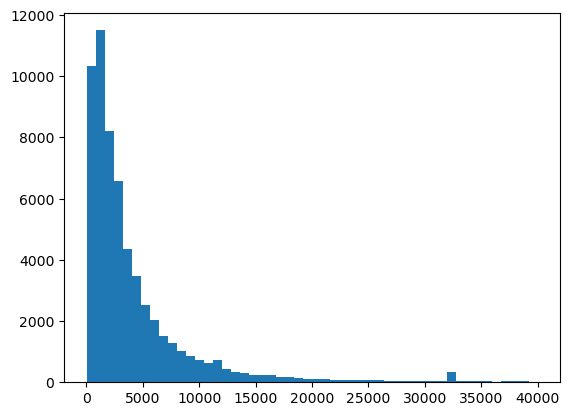

In [45]:
list_hist = [value[1] for key, value in dict_data.items() if len(value[0]) <= 4 and value[1] < 40000]
plt.hist(list_hist, bins=50)

In [46]:
median = np.percentile([value[1] for key, value in dict_data.items() if len(value[0]) <= 4],50)
median

2447.0

In [47]:
dict_data_final2 = {key: value[0] for key, value in dict_data.items() if len(value[0]) <= 4 and value[1] >= median} 

In [48]:
for languages in dict_data_final2.values():
    languages_full_names = [wiki_language_mapping[language] for language in languages]
    for row in range(len(df_connections2)):
        if df_connections2.loc[row,'lang_1'] in languages_full_names and df_connections2.loc[row,'lang_2'] in languages_full_names:
            df_connections2.loc[row,'weight'] += 1

In [50]:
df_connections2

,lang_1,lang_2,weight
0,English,German,2314
1,English,French,2817
2,English,Dutch,799
3,English,Russian,1416
4,English,Spanish,1777
...,...,...,...
185,Catalan,Indonesian,2
186,Catalan,Korean,6
187,Serbian,Indonesian,3
188,Serbian,Korean,2


In [49]:
df_connections2.to_csv('raw/Edges - long articles only.csv')